### Training and running a linear model using Scikit-Learn

In [76]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.neighbors
import urllib.request
import logging

### Configurations ###

logger = logging.getLogger("chapter 1")
logger.setLevel(logging.INFO)

DATA_FOLDER_PATH: str = os.path.join(os.getcwd(), "datasets")
os.makedirs(name=DATA_FOLDER_PATH, exist_ok=True) # Create the folder if it doesn't exist
DATA_SOURCE_ROOT_URL: str = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/lifesat/"
OECD_DATASET_NAME: str = "oecd_bli_2015.csv" # Better life index data from the OECD's website
GDP_DATASET_NAME: str = "gdp_per_capita.csv" # Income per capita from the IMF's website

In [77]:
### Download the data ###

logger.info(f"Downloading {OECD_DATASET_NAME}")
urllib.request.urlretrieve(
    url=f"{DATA_SOURCE_ROOT_URL}{OECD_DATASET_NAME}",
    filename=os.path.join(DATA_FOLDER_PATH, OECD_DATASET_NAME),
)

logger.info(f"Downloading {GDP_DATASET_NAME}")
urllib.request.urlretrieve(
    url=f"{DATA_SOURCE_ROOT_URL}{GDP_DATASET_NAME}",
    filename=os.path.join(DATA_FOLDER_PATH, GDP_DATASET_NAME),
)

INFO:chapter 1:Downloading oecd_bli_2015.csv
INFO:chapter 1:Downloading gdp_per_capita.csv


('/home/luiky/Documents/repositories/handson-ml/chapter_01/datasets/gdp_per_capita.csv',
 <http.client.HTTPMessage at 0x7f1aa60eb970>)

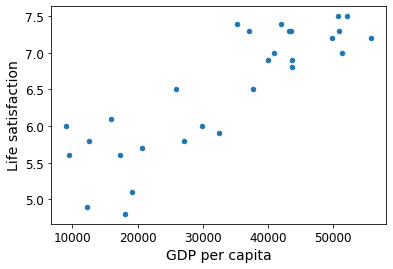

In [78]:
### Helper functions ###
def prepare_country_stats(oecd_bli, gdp_per_capita):
    """
    Function created by the author to clean and prepare the data
    We'll not try to improve it since our goal here is to study Machine Learning
    Basically this will clean and join the datasets
    """
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices] # type: ignore

# Load data
oecd_df: pd.DataFrame = pd.read_csv(
    os.path.join(DATA_FOLDER_PATH, OECD_DATASET_NAME),
    thousands=",",
)
gdp_df: pd.DataFrame = pd.read_csv(
    os.path.join(DATA_FOLDER_PATH, GDP_DATASET_NAME),
    thousands=",",
    delimiter="\t",
    encoding="latin1",
    na_values="n/a",
)

# Prepare the data
country_stats = prepare_country_stats(oecd_df, gdp_df)
# np.c_[] will stack the array in the last axis, i.e. it'll create a list of lists with shape (nb_samples, nb_features)
X: np.ndarray = np.c_[country_stats["GDP per capita"]]
y: np.ndarray = np.c_[country_stats["Life satisfaction"]]

# Visualize the data
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.show()

In [79]:
### Build the linear model ###
linear_model: sklearn.linear_model.LinearRegression = sklearn.linear_model.LinearRegression()
# Train the model
linear_model.fit(
    X=X,
    y=y
)
theta_0: float = linear_model.intercept_[0] # type: ignore
theta_1: float = linear_model.coef_[0][0] # type: ignore
print(f"Intercept: {theta_0:.2f}\nSlope: {theta_1:.5f}")

X_new: list[list[int]] = [[22587]]
print(f"Prediction for Cyprus' GDP per capita with linear regression: {linear_model.predict(X_new)}")

Intercept: 4.85
Slope: 0.00005
Prediction for Cyprus' GDP per capita with linear regression: [[5.96242338]]


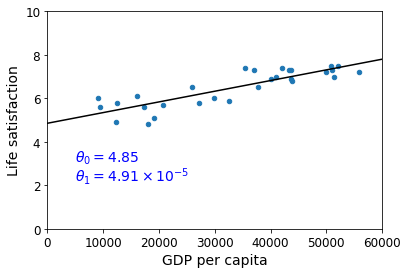

In [80]:
### Visualize the model ###
X_linspace: np.ndarray = np.linspace(0, 60000, 1000)
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.axis([0, 60000, 0, 10])
plt.plot(X_linspace, theta_0 + theta_1*X_linspace, "k")
plt.text(5000, 3.1, r"$\theta_0 = 4.85$", fontsize=14, color="k")
plt.text(5000, 2.2, r"$\theta_1 = 4.91 \times 10^{-5}$", fontsize=14, color="k")
plt.show()

In [81]:
### Build the instance-based algorithm ###
n_neighbors: int = 3
knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=n_neighbors)

# Train the model
knn_model.fit(
    X=X,
    y=y
)

X_new: list[list[int]] = [[22587]]
print(f"Prediction for Cyprus' GDP per capita with knn: {knn_model.predict(X_new)}")

Prediction for Cyprus' GDP per capita with knn: [[5.76666667]]


In [101]:
### Build the linear model with ridge regularization ###
ridge_linear_model: sklearn.linear_model.Ridge = sklearn.linear_model.Ridge(alpha=10**10)

# Train the model
ridge_linear_model.fit(
    X=X,
    y=y
)
ridge_theta_0: float = ridge_linear_model.intercept_[0] # type: ignore
ridge_theta_1: float = ridge_linear_model.coef_[0][0] # type: ignore
print(f"Intercept: {ridge_theta_0:.2f}\nSlope: {ridge_theta_1:.5f}")

X_new: list[list[int]] = [[22587]]
print(f"Prediction for Cyprus' GDP per capita with linear regression: {ridge_linear_model.predict(X_new)}")

Intercept: 5.88
Slope: 0.00002
Prediction for Cyprus' GDP per capita with linear regression: [[6.29390176]]


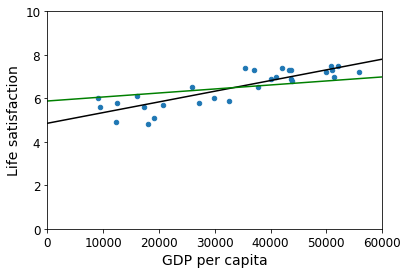

In [103]:
### Visualize the linear model and the ridge one ###
X_linspace: np.ndarray = np.linspace(0, 60000, 1000)
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.axis([0, 60000, 0, 10])
plt.plot(X_linspace, theta_0 + theta_1*X_linspace, "k")
plt.plot(X_linspace, ridge_theta_0 + ridge_theta_1*X_linspace, "g")
plt.show()